# Duration Prediction

In [ ]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [307]:
def preprocessing(df):
    # compute target variables: trip duration in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # keep only trips of less than an hour
    df = df.loc[(df.duration >= 1) & (df.duration <= 60), :]

    # extract trip date components
    df['trip_month'] = pd.Categorical(df.lpep_pickup_datetime.dt.month)
    df['trip_dom'] = pd.Categorical(df.lpep_pickup_datetime.dt.day)
    df['trip_hour'] = pd.Categorical(df.lpep_pickup_datetime.dt.hour)

    # concatenate pickup and dropoff locations
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)

    return df

In [308]:
def one_hot_encoding(df, numerical, categorical, dv=None):
    df[categorical] = df[categorical].astype(str)
    df_dicts = df[categorical + numerical].to_dict(orient='records')

    if not dv:
        dv = DictVectorizer()
        dv.fit(df_dicts)

    X_train = dv.transform(df_dicts)

    return X_train, dv

In [309]:
# read im the raw data
df_train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [310]:
# data cleaning
df_train = preprocessing(df_train)
df_val = preprocessing(df_val)

In [312]:
# variable selection
categorical = ['PU_DO']
numerical = ['trip_distance']

In [313]:
# categorical feature encoding
X_train, dv = one_hot_encoding(df_train, numerical, categorical)
X_val, _ = one_hot_encoding(df_val, numerical, categorical, dv=dv)

In [314]:
target = 'duration'
y_train = df_train[target]
y_val = df_val[target]

In [315]:
lr = LinearRegression()
print(lr)
lr.fit(X_train, y_train)
print(lr)

LinearRegression()

In [316]:
y_pred = lr.predict(X_val)

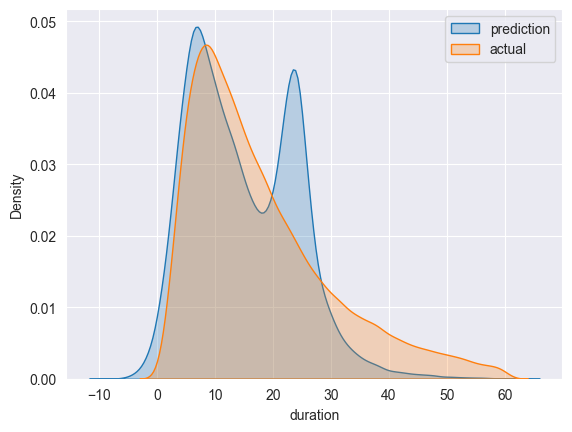

In [317]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [318]:
root_mean_squared_error(y_val, y_pred)

8.414105621065888

In [319]:
lasso = Lasso(alpha=.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

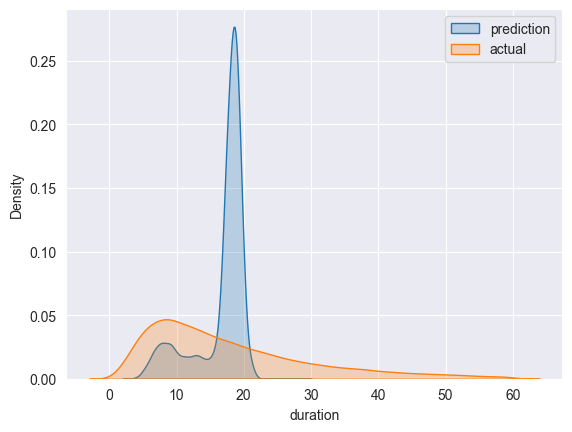

In [320]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [321]:
root_mean_squared_error(y_val, y_pred)

11.171519713869714

In [322]:
ridge = Ridge(alpha=.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)

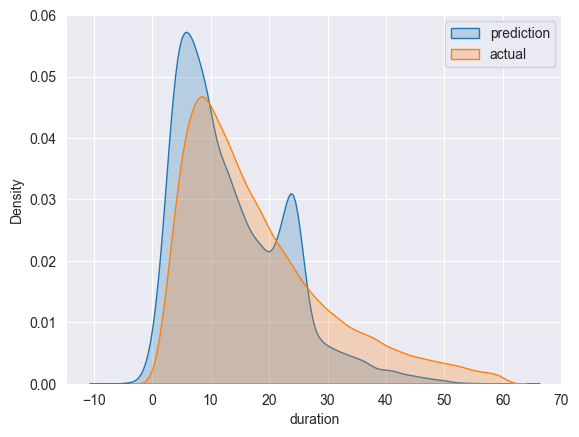

In [323]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [324]:
root_mean_squared_error(y_val, y_pred)

8.419437330179424

In [325]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)